In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import string
import json
import pickle

unk = '<UNK>'

class RNN(nn.Module):
    def __init__(self, input_dim, h):
        super(RNN, self).__init__()
        self.h = h
        self.numOfLayer = 1
        self.rnn = nn.RNN(input_dim, h, self.numOfLayer, nonlinearity='tanh')
        self.W = nn.Linear(h, 5)
        self.softmax = nn.LogSoftmax(dim=1)
        self.loss = nn.NLLLoss()

    def compute_Loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)

    def forward(self, inputs):
        hidden = torch.zeros(self.numOfLayer, 1, self.h)
        _, hidden = self.rnn(inputs, hidden)
        output_layer = self.W(hidden)[:, -1, :]
        predicted_vector = self.softmax(output_layer)
        return predicted_vector

def load_data(train_data, val_data, test_data):
    with open(train_data) as training_f:
        training = json.load(training_f)
    with open(val_data) as valid_f:
        validation = json.load(valid_f)
    with open(test_data) as test_f:
        testing = json.load(test_f)

    tra = []
    val = []
    test = []

    for elt in training:
        tra.append((elt["text"].split(), int(elt["stars"] - 1)))
    for elt in validation:
        val.append((elt["text"].split(), int(elt["stars"] - 1)))
    for elt in testing:
        test.append((elt["text"].split(), int(elt["stars"] - 1)))

    return tra, val, test

if __name__ == "__main__":
    print("========== Loading data ==========")
    train_data, valid_data, test_data = load_data("training.json", "validation.json", "test.json")

    num_train_examples = len(train_data)
    print("Number of examples in the training dataset:", num_train_examples)

    num_val_examples = len(valid_data)
    print("Number of examples in the validation dataset:", num_val_examples)

    num_test_examples = len(test_data)
    print("Number of examples in the testing dataset:", num_test_examples)
   

    # Think about the type of function that an RNN describes. To apply it, you will need to convert the text data into vector representations.
    # Further, think about where the vectors will come from. There are 3 reasonable choices:
    # 1) Randomly assign the input to vectors and learn better embeddings during training; see the PyTorch documentation for guidance
    # 2) Assign the input to vectors using pretrained word embeddings. We recommend any of {Word2Vec, GloVe, FastText}. Then, you do not train/update these embeddings.
    # 3) You do the same as 2) but you train (this is called fine-tuning) the pretrained embeddings further.
    # Option 3 will be the most time consuming, so we do not recommend starting with this

    print("========== Vectorizing data ==========")
    model = RNN(50, h=50)  # Fill in parameters
    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    word_embedding = pickle.load(open('./word_embedding.pkl', 'rb'))

    stopping_condition = False
    epoch = 0

    last_train_accuracy = 0
    last_validation_accuracy = 0
    
    epoch_number = 0
    accuracy_val = []
    training_losses = []

    while not stopping_condition and epoch_number  < 5:
        epoch_number = epoch_number + 1
        random.shuffle(train_data)
        model.train()
        # You will need further code to operationalize training, ffnn.py may be helpful
        print("Training started for epoch {}".format(epoch + 1))
        train_data = train_data
        correct = 0
        total = 0
        minibatch_size = 16
        N = len(train_data)

        loss_total = 0
        loss_count = 0
        for minibatch_index in tqdm(range(N // minibatch_size)):
            optimizer.zero_grad()
            loss = None
            for example_index in range(minibatch_size):
                input_words, gold_label = train_data[minibatch_index * minibatch_size + example_index]
                input_words = " ".join(input_words)

                # Remove punctuation
                input_words = input_words.translate(input_words.maketrans("", "", string.punctuation)).split()

                # Look up word embedding dictionary
                vectors = [word_embedding[i.lower()] if i.lower() in word_embedding.keys() else word_embedding['unk'] for i in input_words ]

                # Transform the input into required shape
                vectors = torch.tensor(vectors).view(len(vectors), 1, -1)
                output = model(vectors)

                # Get loss
                example_loss = model.compute_Loss(output.view(1,-1), torch.tensor([gold_label]))

                # Get predicted label
                predicted_label = torch.argmax(output)

                correct += int(predicted_label == gold_label)
                # print(predicted_label, gold_label)
                total += 1
                if loss is None:
                    loss = example_loss
                else:
                    loss += example_loss

            loss = loss / minibatch_size
            loss_total += loss.data
            loss_count += 1
            loss.backward()
            optimizer.step()
        print(loss_total/loss_count)

        training_losses.append(1 - (correct/total))
        print("Training completed for epoch {}".format(epoch + 1))
        print("Training accuracy for epoch {}: {}".format(epoch + 1, correct / total))
        trainning_accuracy = correct/total


        model.eval()
        correct = 0
        total = 0
        random.shuffle(valid_data)
        print("Validation started for epoch {}".format(epoch + 1))
        valid_data = valid_data

        for input_words, gold_label in tqdm(valid_data):
            input_words = " ".join(input_words)
            input_words = input_words.translate(input_words.maketrans("", "", string.punctuation)).split()
            vectors = [word_embedding[i.lower()] if i.lower() in word_embedding.keys() else word_embedding['unk'] for i
                       in input_words]

            vectors = torch.tensor(vectors).view(len(vectors), 1, -1)
            output = model(vectors)
            predicted_label = torch.argmax(output)
            correct += int(predicted_label == gold_label)
            total += 1
            # print(predicted_label, gold_label)

        accuracy_val.append((correct/total))
        print("Validation completed for epoch {}".format(epoch + 1))
        print("Validation accuracy for epoch {}: {}".format(epoch + 1, correct / total))
        validation_accuracy = correct/total

        if validation_accuracy < last_validation_accuracy and trainning_accuracy > last_train_accuracy:
            stopping_condition=True
            print("Training done to avoid overfitting!")
            print("Best validation accuracy is:", last_validation_accuracy)
        else:
            last_validation_accuracy = validation_accuracy
            last_train_accuracy = trainning_accuracy

        epoch += 1



    # You may find it beneficial to keep track of training accuracy or training loss;

    # Think about how to update the model and what this entails. Consider ffnn.py and the PyTorch documentation for guidance


========== Loading data ==========
Number of examples in the training dataset: 16000
Number of examples in the validation dataset: 800
Number of examples in the testing dataset: 800
========== Vectorizing data ==========
Training started for epoch 1


100%|███████████████████████████████████████| 1000/1000 [01:15<00:00, 13.23it/s]


tensor(1.6426)
Training completed for epoch 1
Training accuracy for epoch 1: 0.2285
Validation started for epoch 1


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 456.63it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.2
Training started for epoch 2


100%|███████████████████████████████████████| 1000/1000 [01:11<00:00, 14.03it/s]


tensor(1.6334)
Training completed for epoch 2
Training accuracy for epoch 2: 0.23725
Validation started for epoch 2


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 475.14it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.3
Training started for epoch 3


100%|███████████████████████████████████████| 1000/1000 [01:13<00:00, 13.62it/s]


tensor(1.6350)
Training completed for epoch 3
Training accuracy for epoch 3: 0.2295
Validation started for epoch 3


100%|████████████████████████████████████████| 800/800 [00:02<00:00, 381.15it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.26625
Training started for epoch 4


100%|███████████████████████████████████████| 1000/1000 [01:12<00:00, 13.74it/s]


tensor(1.6364)
Training completed for epoch 4
Training accuracy for epoch 4: 0.2276875
Validation started for epoch 4


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 450.09it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.06375
Training started for epoch 5


100%|███████████████████████████████████████| 1000/1000 [01:10<00:00, 14.20it/s]


tensor(1.6422)
Training completed for epoch 5
Training accuracy for epoch 5: 0.2300625
Validation started for epoch 5


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 460.51it/s]

Validation completed for epoch 5
Validation accuracy for epoch 5: 0.1375


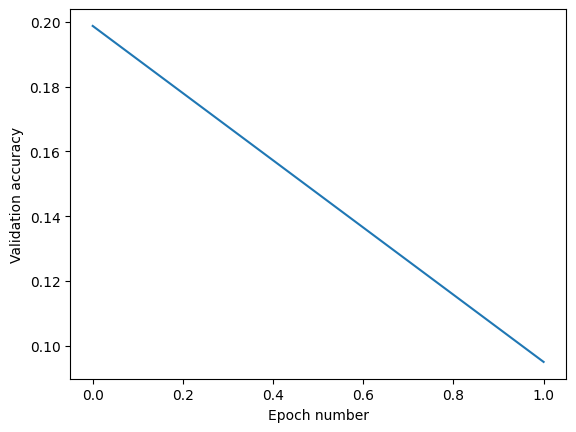

In [15]:
epoch_num = [i for i in range(len(accuracy_val))]
from matplotlib import pyplot as plt
plt.plot(epoch_num, accuracy_val)
plt.xlabel("Epoch number")
plt.ylabel("Validation accuracy")
plt.show()

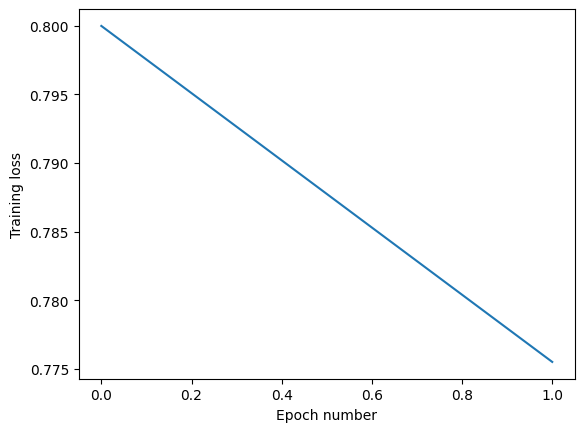

In [16]:
poch_num = [i for i in range(len(training_losses))]
from matplotlib import pyplot as plt
plt.plot(epoch_num, training_losses)
plt.xlabel("Epoch number")
plt.ylabel("Training loss")
plt.show()

In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
import math
import random
import os
import time
from tqdm import tqdm
import json
from argparse import ArgumentParser


unk = '<UNK>'
# Consult the PyTorch documentation for information on the functions used below:
# https://pytorch.org/docs/stable/torch.html
class FFNN(nn.Module):
    def __init__(self, input_dim, h):
        super(FFNN, self).__init__()
        self.h = h
        self.W1 = nn.Linear(input_dim, h)
        self.activation = nn.ReLU() # The rectified linear unit; one valid choice of activation function
        self.output_dim = 5
        self.W2 = nn.Linear(h, self.output_dim)

        self.softmax = nn.LogSoftmax() # The softmax function that converts vectors into probability distributions; computes log probabilities for computational benefits
        self.loss = nn.NLLLoss() # The cross-entropy/negative log likelihood loss taught in class

    def compute_Loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)

    def forward(self, input_vector):
        # [to fill] obtain first hidden layer representation
        hidden_layer1 = self.W1(input_vector)
        hidden_layer1 = self.activation(hidden_layer1)

        # [to fill] obtain output layer representation
        hidden_layer2 = self.W2(hidden_layer1)
        hidden_layer2 = self.activation(hidden_layer2)

        # [to fill] obtain probability dist.
        predicted_vector = self.softmax(hidden_layer2)
        return predicted_vector


# Returns: 
# vocab = A set of strings corresponding to the vocabulary
def make_vocab(data):
    vocab = set()
    for document, _ in data:
        for word in document:
            vocab.add(word)
    return vocab 


# Returns:
# vocab = A set of strings corresponding to the vocabulary including <UNK>
# word2index = A dictionary mapping word/token to its index (a number in 0, ..., V - 1)
# index2word = A dictionary inverting the mapping of word2index
def make_indices(vocab):
    vocab_list = sorted(vocab)
    vocab_list.append(unk)
    word2index = {}
    index2word = {}
    for index, word in enumerate(vocab_list):
        word2index[word] = index 
        index2word[index] = word 
    vocab.add(unk)
    return vocab, word2index, index2word 


# Returns:
# vectorized_data = A list of pairs (vector representation of input, y)
def convert_to_vector_representation(data, word2index):
    vectorized_data = []
    for document, y in data:
        vector = torch.zeros(len(word2index)) 
        for word in document:
            index = word2index.get(word, word2index[unk])
            vector[index] += 1
        vectorized_data.append((vector, y))
    return vectorized_data



def load_data(train_data, val_data):
    with open(train_data) as training_f:
        training = json.load(training_f)
    with open(val_data) as valid_f:
        validation = json.load(valid_f)

    tra = []
    val = []
    for elt in training:
        tra.append((elt["text"].split(),int(elt["stars"]-1)))
    for elt in validation:
        val.append((elt["text"].split(),int(elt["stars"]-1)))

    return tra, val


if __name__ == "__main__":
#     parser = ArgumentParser()
#     parser.add_argument("-hd", "--hidden_dim", type=int, required = True, help = "hidden_dim")
#     parser.add_argument("-e", "--epochs", type=int, required = True, help = "num of epochs to train")
#     parser.add_argument("--train_data", required = True, help = "path to training data")
#     parser.add_argument("--val_data", required = True, help = "path to validation data")
#     parser.add_argument("--test_data", default = "to fill", help = "path to test data")
#     parser.add_argument('--do_train', action='store_true')
#     args = parser.parse_args()

    # fix random seeds
    random.seed(42)
    torch.manual_seed(42)

    # load data
    print("========== Loading data ==========")
    train_data, valid_data = load_data("training.json", "validation.json") # X_data is a list of pairs (document, y); y in {0,1,2,3,4}
    train_data, test_data = load_data("training.json","test.json")
    vocab = make_vocab(train_data)
    vocab, word2index, index2word = make_indices(vocab)

    print("========== Vectorizing data ==========")
    train_data = convert_to_vector_representation(train_data, word2index)
    valid_data = convert_to_vector_representation(valid_data, word2index)
    

    model = FFNN(input_dim = len(vocab), h = 10)
    optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)
    print("========== Training for {} epochs ==========".format(5))
    for epoch in range(5):
        model.train()
        optimizer.zero_grad()
        loss = None
        correct = 0
        total = 0
        start_time = time.time()
        print("Training started for epoch {}".format(epoch + 1))
        random.shuffle(train_data) # Good practice to shuffle order of training data
        minibatch_size = 16 
        N = len(train_data) 
        for minibatch_index in tqdm(range(N // minibatch_size)):
            optimizer.zero_grad()
            loss = None
            for example_index in range(minibatch_size):
                input_vector, gold_label = train_data[minibatch_index * minibatch_size + example_index]
                predicted_vector = model(input_vector)
                predicted_label = torch.argmax(predicted_vector)
                correct += int(predicted_label == gold_label)
                total += 1
                example_loss = model.compute_Loss(predicted_vector.view(1,-1), torch.tensor([gold_label]))
                if loss is None:
                    loss = example_loss
                else:
                    loss += example_loss
            loss = loss / minibatch_size
            loss.backward()
            optimizer.step()
        print("Training completed for epoch {}".format(epoch + 1))
        print("Training accuracy for epoch {}: {}".format(epoch + 1, correct / total))
        print("Training time for this epoch: {}".format(time.time() - start_time))


        loss = None
        correct = 0
        total = 0
        start_time = time.time()
        print("Validation started for epoch {}".format(epoch + 1))
        minibatch_size = 16 
        N = len(valid_data) 
        for minibatch_index in tqdm(range(N // minibatch_size)):
            optimizer.zero_grad()
            loss = None
            for example_index in range(minibatch_size):
                input_vector, gold_label = valid_data[minibatch_index * minibatch_size + example_index]
                predicted_vector = model(input_vector)
                predicted_label = torch.argmax(predicted_vector)
                correct += int(predicted_label == gold_label)
                total += 1
                example_loss = model.compute_Loss(predicted_vector.view(1,-1), torch.tensor([gold_label]))
                if loss is None:
                    loss = example_loss
                else:
                    loss += example_loss
            loss = loss / minibatch_size
        print("Validation completed for epoch {}".format(epoch + 1))
        print("Validation accuracy for epoch {}: {}".format(epoch + 1, correct / total))
        print("Validation time for this epoch: {}".format(time.time() - start_time))

        
    # testing
    loss = None
    correct = 0
    total = 0
    start_time = time.time()
    minibatch_size = 16 
    N = len(test_data) 
    for minibatch_index in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        loss = None
        for example_index in range(minibatch_size):
            input_vector, gold_label = valid_data[minibatch_index * minibatch_size + example_index]
            predicted_vector = model(input_vector)
            predicted_label = torch.argmax(predicted_vector)
            correct += int(predicted_label == gold_label)
            total += 1
            example_loss = model.compute_Loss(predicted_vector.view(1,-1), torch.tensor([gold_label]))
            if loss is None:
                loss = example_loss
            else:
                loss += example_loss
        loss = loss / minibatch_size
    print("\nTest completed")
    print("Test accuracy: {}".format(correct / total))
    print("Test time: {}".format(time.time() - start_time))


    # write out to results/test.out
    

========== Loading data ==========
========== Vectorizing data ==========
========== Training for 5 epochs ==========
Training started for epoch 1


  0%|                                                  | 0/1000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 85.28it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.332125
Training time for this epoch: 11.747113943099976
Validation started for epoch 1


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 185.90it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.33625
Validation time for this epoch: 0.27137017250061035
Training started for epoch 2


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 91.49it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.44925
Training time for this epoch: 10.982587099075317
Validation started for epoch 2


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 191.21it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.30875
Validation time for this epoch: 0.2630348205566406
Training started for epoch 3


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 87.35it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.5221875
Training time for this epoch: 11.498985052108765
Validation started for epoch 3


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 213.55it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.51
Validation time for this epoch: 0.23591089248657227
Training started for epoch 4


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.86it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.5538125
Training time for this epoch: 10.075731039047241
Validation started for epoch 4


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 204.53it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.4925
Validation time for this epoch: 0.2460339069366455
Training started for epoch 5


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 95.41it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.5816875
Training time for this epoch: 10.530571937561035
Validation started for epoch 5


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 214.81it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.56
Validation time for this epoch: 0.23421216011047363


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 377.14it/s]


Test completed
Test accuracy: 0.56
Test time: 0.13387107849121094


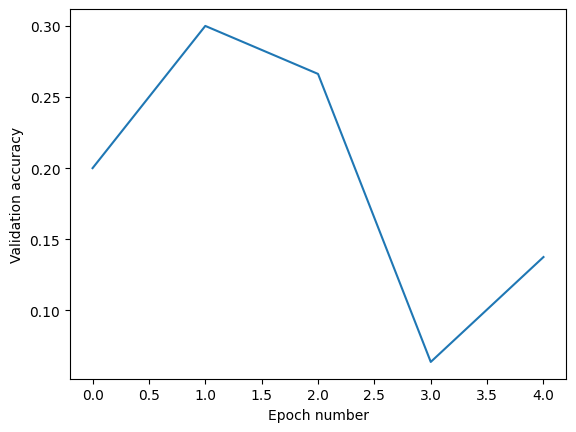

In [18]:
epoch_num = [i for i in range(len(accuracy_val))]
from matplotlib import pyplot as plt
plt.plot(epoch_num, accuracy_val)
plt.xlabel("Epoch number")
plt.ylabel("Validation accuracy")
plt.show()

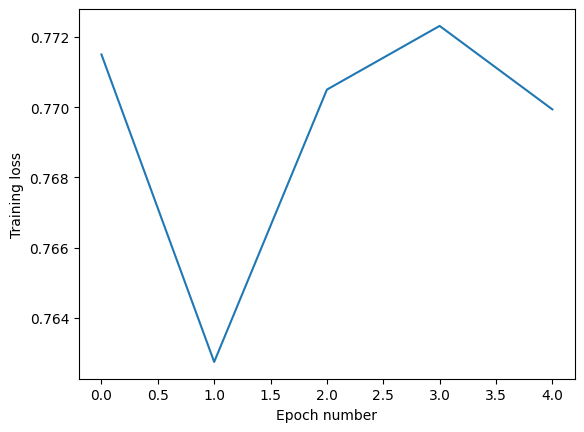

In [19]:
poch_num = [i for i in range(len(training_losses))]
from matplotlib import pyplot as plt
plt.plot(epoch_num, training_losses)
plt.xlabel("Epoch number")
plt.ylabel("Training loss")
plt.show()

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm
import json
import random
import optuna

unk = '<UNK>'

class FFNN(nn.Module):
    
    def __init__(self, input_dim, h):
        super(FFNN, self).__init__()
        self.h = h
        self.W1 = nn.Linear(input_dim, h)
        self.activation = nn.ReLU()
        self.output_dim = 5
        self.W2 = nn.Linear(h, self.output_dim)

        self.softmax = nn.LogSoftmax()
        self.loss = nn.NLLLoss()

    def compute_Loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)

    def forward(self, input_vector):
        hidden_layer1 = self.W1(input_vector)
        hidden_layer1 = self.activation(hidden_layer1)
        hidden_layer2 = self.W2(hidden_layer1)
        hidden_layer2 = self.activation(hidden_layer2)
        predicted_vector = self.softmax(hidden_layer2)
        return predicted_vector

def make_vocab(data):
    vocab = set()
    for document, _ in data:
        for word in document:
            vocab.add(word)
    return vocab

def make_indices(vocab):
    vocab_list = sorted(vocab)
    vocab_list.append(unk)
    word2index = {}
    index2word = {}
    for index, word in enumerate(vocab_list):
        word2index[word] = index
        index2word[index] = word
    vocab.add(unk)
    return vocab, word2index, index2word

def convert_to_vector_representation(data, word2index):
    vectorized_data = []
    for document, y in data:
        vector = torch.zeros(len(word2index))
        for word in document:
            index = word2index.get(word, word2index[unk])
            vector[index] += 1
        vectorized_data.append((vector, y))
    return vectorized_data

def load_data(train_data, val_data):
    with open(train_data) as training_f:
        training = json.load(training_f)
    with open(val_data) as valid_f:
        validation = json.load(valid_f)

    tra = []
    val = []
    for elt in training:
        tra.append((elt["text"].split(), int(elt["stars"] - 1)))
    for elt in validation:
        val.append((elt["text"].split(), int(elt["stars"] - 1)))

    return tra, val

if __name__ == "__main__":
    
    random.seed(42)
    torch.manual_seed(42)

    train_data, valid_data = load_data("training.json", "validation.json")
    train_data, test_data = load_data("training.json", "test.json")
    vocab = make_vocab(train_data)
    vocab, word2index, index2word = make_indices(vocab)

    train_data = convert_to_vector_representation(train_data, word2index)
    valid_data = convert_to_vector_representation(valid_data, word2index)

    def objective(trial):
        h = trial.suggest_int('h', 5, 50)
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

        model = FFNN(input_dim=len(vocab), h=h)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

        for epoch in range(5):
            model.train()
            optimizer.zero_grad()
            loss = None
            correct = 0
            total = 0
            start_time = time.time()

            random.shuffle(train_data)
            minibatch_size = 16
            N = len(train_data)

            for minibatch_index in tqdm(range(N // minibatch_size)):
                optimizer.zero_grad()
                loss = None

                for example_index in range(minibatch_size):
                    input_vector, gold_label = train_data[minibatch_index * minibatch_size + example_index]
                    predicted_vector = model(input_vector)
                    predicted_label = torch.argmax(predicted_vector)
                    correct += int(predicted_label == gold_label)
                    total += 1
                    example_loss = model.compute_Loss(predicted_vector.view(1, -1), torch.tensor([gold_label]))

                    if loss is None:
                        loss = example_loss
                    else:
                        loss += example_loss

                loss = loss / minibatch_size
                loss.backward()
                optimizer.step()

            print("Training completed for epoch {}".format(epoch + 1))
            print("Training accuracy for epoch {}: {}".format(epoch + 1, correct / total))
            print("Training time for this epoch: {}".format(time.time() - start_time))

            loss = None
            correct = 0
            total = 0
            start_time = time.time()

            minibatch_size = 16
            N = len(valid_data)

            for minibatch_index in tqdm(range(N // minibatch_size)):
                optimizer.zero_grad()
                loss = None

                for example_index in range(minibatch_size):
                    input_vector, gold_label = valid_data[minibatch_index * minibatch_size + example_index]
                    predicted_vector = model(input_vector)
                    predicted_label = torch.argmax(predicted_vector)
                    correct += int(predicted_label == gold_label)
                    total += 1
                    example_loss = model.compute_Loss(predicted_vector.view(1, -1), torch.tensor([gold_label]))

                    if loss is None:
                        loss = example_loss
                    else:
                        loss += example_loss

                loss = loss / minibatch_size

            print("Validation completed for epoch {}".format(epoch + 1))
            print("Validation accuracy for epoch {}: {}".format(epoch + 1, correct / total))
            print("Validation time for this epoch: {}".format(time.time() - start_time))

        validation_accuracy = correct / total
        return -validation_accuracy

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    best_h = study.best_params['h']
    best_learning_rate = study.best_params['learning_rate']
    print(f"Best hidden layer size: {best_h}")
    print(f"Best learning rate: {best_learning_rate}")

    best_model = FFNN(input_dim=len(vocab), h=best_h)
    best_optimizer = optim.SGD(best_model.parameters(), lr=best_learning_rate, momentum=0.9)

    loss = None
    correct = 0
    total = 0
    start_time = time.time()
    minibatch_size = 16
    N = len(test_data)

    for minibatch_index in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        loss = None

        for example_index in range(minibatch_size):
            input_vector, gold_label = valid_data[minibatch_index * minibatch_size + example_index]
            predicted_vector = best_model(input_vector)
            predicted_label = torch.argmax(predicted_vector)
            correct += int(predicted_label == gold_label)
            total += 1
            example_loss = best_model.compute_Loss(predicted_vector.view(1, -1), torch.tensor([gold_label]))

            if loss is None:
                loss = example_loss
            else:
                loss += example_loss

        loss = loss / minibatch_size

    print("\nTest completed")
    print("Test accuracy: {}".format(correct / total))
    print("Test time: {}".format(time.time() - start_time))


[I 2023-11-08 00:13:17,710] A new study created in memory with name: no-name-3b6ccd8d-6668-4971-a065-ca14ed0ff9a1
/var/folders/wg/z02q97mn2tlf1q3bg_scj4280000gn/T/ipykernel_12612/3372619450.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
  0%|                                                  | 0/1000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|███████████████████████████████████████| 1000/1000 [00:36<00:00, 27.58it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.277375
Training time for this epoch: 36.27450394630432


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 156.39it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.48125
Validation time for this epoch: 0.3207728862762451


100%|███████████████████████████████████████| 1000/1000 [00:36<00:00, 27.07it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.489375
Training time for this epoch: 36.9472279548645


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 155.93it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.54625
Validation time for this epoch: 0.3217639923095703


100%|███████████████████████████████████████| 1000/1000 [00:36<00:00, 27.59it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.5370625
Training time for this epoch: 36.260249853134155


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 168.59it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.58875
Validation time for this epoch: 0.29755592346191406


100%|███████████████████████████████████████| 1000/1000 [00:35<00:00, 28.07it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.5709375
Training time for this epoch: 35.63276386260986


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 162.70it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.455
Validation time for this epoch: 0.30829811096191406


100%|███████████████████████████████████████| 1000/1000 [00:36<00:00, 27.26it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.60675
Training time for this epoch: 36.688658237457275


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 148.60it/s]
[I 2023-11-08 00:16:21,499] Trial 0 finished with value: -0.52625 and parameters: {'h': 40, 'learning_rate': 0.006239385399383071}. Best is trial 0 with value: -0.52625.
/var/folders/wg/z02q97mn2tlf1q3bg_scj4280000gn/T/ipykernel_12612/3372619450.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.52625
Validation time for this epoch: 0.33761000633239746


100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 148.75it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.2395625
Training time for this epoch: 6.73345422744751


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 338.10it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.18875
Validation time for this epoch: 0.14896583557128906


100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 145.86it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.3118125
Training time for this epoch: 6.861873149871826


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 315.31it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.245
Validation time for this epoch: 0.15959715843200684


100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 147.30it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.3623125
Training time for this epoch: 6.794590950012207


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 316.77it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.2875
Validation time for this epoch: 0.15893197059631348


100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 145.03it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.3878125
Training time for this epoch: 6.900513648986816


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 309.76it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.3075
Validation time for this epoch: 0.1625990867614746


100%|██████████████████████████████████████| 1000/1000 [00:07<00:00, 138.08it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.406125
Training time for this epoch: 7.250053882598877


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 228.49it/s]
[I 2023-11-08 00:16:56,936] Trial 1 finished with value: -0.33875 and parameters: {'h': 8, 'learning_rate': 8.027104014094393e-05}. Best is trial 0 with value: -0.52625.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.33875
Validation time for this epoch: 0.22121119499206543


100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 25.86it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.286125
Training time for this epoch: 38.670629262924194


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 146.49it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.39
Validation time for this epoch: 0.342379093170166


100%|███████████████████████████████████████| 1000/1000 [00:39<00:00, 25.39it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.354625
Training time for this epoch: 39.38872408866882


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 150.28it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.37
Validation time for this epoch: 0.3337411880493164


100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 25.71it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.397375
Training time for this epoch: 38.90782809257507


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 149.36it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.405
Validation time for this epoch: 0.3358311653137207


100%|███████████████████████████████████████| 1000/1000 [00:39<00:00, 25.40it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.415125
Training time for this epoch: 39.370898962020874


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 150.84it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.41375
Validation time for this epoch: 0.33264923095703125


100%|███████████████████████████████████████| 1000/1000 [00:39<00:00, 25.32it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.4289375
Training time for this epoch: 39.50763702392578


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 149.95it/s]
[I 2023-11-08 00:20:14,479] Trial 2 finished with value: -0.435 and parameters: {'h': 44, 'learning_rate': 0.00010971350514334845}. Best is trial 0 with value: -0.52625.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.435
Validation time for this epoch: 0.3345150947570801


100%|██████████████████████████████████████| 1000/1000 [00:07<00:00, 138.65it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.3155
Training time for this epoch: 7.217831134796143


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 311.61it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.3375
Validation time for this epoch: 0.16153788566589355


100%|██████████████████████████████████████| 1000/1000 [00:07<00:00, 138.15it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.4331875
Training time for this epoch: 7.244760036468506


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 325.96it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.38625
Validation time for this epoch: 0.15447402000427246


100%|██████████████████████████████████████| 1000/1000 [00:07<00:00, 138.28it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.473375
Training time for this epoch: 7.236922025680542


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 289.16it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.51375
Validation time for this epoch: 0.17394304275512695


100%|██████████████████████████████████████| 1000/1000 [00:07<00:00, 139.25it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.497875
Training time for this epoch: 7.187495231628418


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 309.27it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.43125
Validation time for this epoch: 0.16275811195373535


100%|██████████████████████████████████████| 1000/1000 [00:07<00:00, 137.49it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.522875
Training time for this epoch: 7.27873420715332


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 308.93it/s]
[I 2023-11-08 00:20:51,468] Trial 3 finished with value: -0.4575 and parameters: {'h': 9, 'learning_rate': 0.0003967542832464048}. Best is trial 0 with value: -0.52625.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.4575
Validation time for this epoch: 0.16291093826293945


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.36it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.224
Training time for this epoch: 28.289268970489502


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 181.95it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.17875
Validation time for this epoch: 0.2758290767669678


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.56it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.2924375
Training time for this epoch: 28.126395225524902


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 175.76it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.16625
Validation time for this epoch: 0.2868521213531494


100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 34.40it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.3091875
Training time for this epoch: 29.07908320426941


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 185.27it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.16625
Validation time for this epoch: 0.27136993408203125


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 34.57it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.3196875
Training time for this epoch: 28.932389736175537


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 174.22it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.17875
Validation time for this epoch: 0.288067102432251


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 34.95it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.327625
Training time for this epoch: 28.621325969696045


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 189.37it/s]
[I 2023-11-08 00:23:15,918] Trial 4 finished with value: -0.1825 and parameters: {'h': 32, 'learning_rate': 7.790285090335068e-05}. Best is trial 0 with value: -0.52625.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.1825
Validation time for this epoch: 0.26504993438720703


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.76it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.3185
Training time for this epoch: 31.486871004104614


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 169.23it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.4375
Validation time for this epoch: 0.29654598236083984


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.40it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.396875
Training time for this epoch: 31.864407777786255


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 178.36it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.465
Validation time for this epoch: 0.28139591217041016


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.80it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.429375
Training time for this epoch: 31.463928937911987


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 162.12it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.49875
Validation time for this epoch: 0.3094007968902588


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.44it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.44925
Training time for this epoch: 31.816148281097412


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 156.37it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.51625
Validation time for this epoch: 0.3208589553833008


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.75it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.4671875
Training time for this epoch: 31.510315895080566


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 171.36it/s]
[I 2023-11-08 00:25:55,580] Trial 5 finished with value: -0.52125 and parameters: {'h': 36, 'learning_rate': 0.0006886196263349935}. Best is trial 0 with value: -0.52625.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.52125
Validation time for this epoch: 0.2928156852722168


100%|███████████████████████████████████████| 1000/1000 [00:35<00:00, 27.95it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.3955625
Training time for this epoch: 35.789408922195435


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 119.69it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.45375
Validation time for this epoch: 0.41881275177001953


100%|███████████████████████████████████████| 1000/1000 [00:37<00:00, 26.95it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.51875
Training time for this epoch: 37.12836980819702


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 161.58it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.5375
Validation time for this epoch: 0.3104407787322998


100%|███████████████████████████████████████| 1000/1000 [00:36<00:00, 27.52it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.562875
Training time for this epoch: 36.33873987197876


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 149.38it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.45625
Validation time for this epoch: 0.3357417583465576


100%|███████████████████████████████████████| 1000/1000 [00:37<00:00, 26.89it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.593375
Training time for this epoch: 37.19772291183472


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 153.85it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.5325
Validation time for this epoch: 0.3260190486907959


100%|███████████████████████████████████████| 1000/1000 [00:36<00:00, 27.21it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.621125
Training time for this epoch: 36.75146794319153


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 150.27it/s]
[I 2023-11-08 00:29:00,526] Trial 6 finished with value: -0.53375 and parameters: {'h': 40, 'learning_rate': 0.004003467140634636}. Best is trial 6 with value: -0.53375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.53375
Validation time for this epoch: 0.334061861038208


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 34.81it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.2455625
Training time for this epoch: 28.733136892318726


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 178.08it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.4525
Validation time for this epoch: 0.2816929817199707


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 34.70it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.322625
Training time for this epoch: 28.827733039855957


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 161.66it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.4425
Validation time for this epoch: 0.3102738857269287


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.39it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.3624375
Training time for this epoch: 28.260725021362305


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 184.64it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.44
Validation time for this epoch: 0.27181291580200195


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.30it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.3769375
Training time for this epoch: 28.3381769657135


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 181.96it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.43625
Validation time for this epoch: 0.2759590148925781


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 34.76it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.3884375
Training time for this epoch: 28.77695894241333


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 181.73it/s]
[I 2023-11-08 00:31:24,893] Trial 7 finished with value: -0.4275 and parameters: {'h': 32, 'learning_rate': 5.624353734787035e-05}. Best is trial 6 with value: -0.53375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.4275
Validation time for this epoch: 0.27616119384765625


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 88.96it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.20625
Training time for this epoch: 11.249281883239746


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 245.07it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.4
Validation time for this epoch: 0.2050318717956543


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 90.14it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.2001875
Training time for this epoch: 11.11031198501587


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 248.98it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.4
Validation time for this epoch: 0.2018129825592041


100%|███████████████████████████████████████| 1000/1000 [00:12<00:00, 82.55it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.206125
Training time for this epoch: 12.12000298500061


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 233.31it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.4
Validation time for this epoch: 0.2168409824371338


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 89.67it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.2
Training time for this epoch: 11.164527893066406


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 242.12it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.4
Validation time for this epoch: 0.2075047492980957


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 89.21it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.2
Training time for this epoch: 11.215682029724121


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 232.19it/s]
[I 2023-11-08 00:32:22,811] Trial 8 finished with value: -0.4 and parameters: {'h': 16, 'learning_rate': 0.05696696809540946}. Best is trial 6 with value: -0.53375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.4
Validation time for this epoch: 0.21630406379699707


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 30.68it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.2203125
Training time for this epoch: 32.59576392173767


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 151.57it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.40125
Validation time for this epoch: 0.33094310760498047


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 30.41it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.327375
Training time for this epoch: 32.89395499229431


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 166.66it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.51375
Validation time for this epoch: 0.30103302001953125


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 30.69it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.407875
Training time for this epoch: 32.58483815193176


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 171.91it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.58125
Validation time for this epoch: 0.29181504249572754


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 31.10it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.4303125
Training time for this epoch: 32.16577100753784


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 168.32it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.57625
Validation time for this epoch: 0.29799413681030273


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 30.67it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.444625
Training time for this epoch: 32.61015582084656


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 170.78it/s]
[I 2023-11-08 00:35:07,194] Trial 9 finished with value: -0.55 and parameters: {'h': 36, 'learning_rate': 0.015790296308639575}. Best is trial 9 with value: -0.55.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.55
Validation time for this epoch: 0.2937469482421875


100%|███████████████████████████████████████| 1000/1000 [00:46<00:00, 21.68it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.1994375
Training time for this epoch: 46.13443994522095


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 126.30it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.4
Validation time for this epoch: 0.3969259262084961


100%|███████████████████████████████████████| 1000/1000 [00:46<00:00, 21.39it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.2
Training time for this epoch: 46.755529165267944


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 129.18it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.4
Validation time for this epoch: 0.3880472183227539


100%|███████████████████████████████████████| 1000/1000 [00:47<00:00, 21.27it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.2
Training time for this epoch: 47.01720905303955


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 138.18it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.4
Validation time for this epoch: 0.3628730773925781


100%|███████████████████████████████████████| 1000/1000 [00:46<00:00, 21.52it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.2
Training time for this epoch: 46.47489404678345


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 139.88it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.4
Validation time for this epoch: 0.358565092086792


100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 21.88it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.2
Training time for this epoch: 45.71187090873718


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 136.07it/s]
[I 2023-11-08 00:39:01,232] Trial 10 finished with value: -0.4 and parameters: {'h': 50, 'learning_rate': 0.061346293030362084}. Best is trial 9 with value: -0.55.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.4
Validation time for this epoch: 0.368488073348999


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.03it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.2923125
Training time for this epoch: 20.824774742126465


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 228.07it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.435
Validation time for this epoch: 0.22020602226257324


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.85it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.3710625
Training time for this epoch: 20.477910041809082


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 211.24it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.43
Validation time for this epoch: 0.23761272430419922


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 47.76it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.4201875
Training time for this epoch: 20.94304633140564


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 220.62it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.5275
Validation time for this epoch: 0.22768688201904297


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 47.88it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.4563125
Training time for this epoch: 20.8933207988739


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 222.64it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.595
Validation time for this epoch: 0.22560596466064453


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.13it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.4725625
Training time for this epoch: 20.780906677246094


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 219.78it/s]
[I 2023-11-08 00:40:46,322] Trial 11 finished with value: -0.56375 and parameters: {'h': 24, 'learning_rate': 0.00724996284919709}. Best is trial 11 with value: -0.56375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.56375
Validation time for this epoch: 0.2285318374633789


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.12it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.2425
Training time for this epoch: 17.824121952056885


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 229.84it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.34625
Validation time for this epoch: 0.21850132942199707


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.79it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.257625
Training time for this epoch: 17.614715099334717


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 228.06it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.36625
Validation time for this epoch: 0.2202739715576172


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 55.96it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.2846875
Training time for this epoch: 17.87783908843994


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 231.25it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.36625
Validation time for this epoch: 0.2171781063079834


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 55.48it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.29975
Training time for this epoch: 18.02861213684082


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 214.55it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.37125
Validation time for this epoch: 0.2340841293334961


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.69it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.3201875
Training time for this epoch: 17.645405769348145


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 246.92it/s]
[I 2023-11-08 00:42:16,422] Trial 12 finished with value: -0.38125 and parameters: {'h': 21, 'learning_rate': 1.0339306344000748e-05}. Best is trial 11 with value: -0.56375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.38125
Validation time for this epoch: 0.20349788665771484


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 47.98it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.378375
Training time for this epoch: 20.84554624557495


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 221.19it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.5275
Validation time for this epoch: 0.22705483436584473


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.97it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.4945625
Training time for this epoch: 21.302849054336548


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 211.33it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.4825
Validation time for this epoch: 0.23763298988342285


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 47.54it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.5378125
Training time for this epoch: 21.040269136428833


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 227.92it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.48875
Validation time for this epoch: 0.22040867805480957


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 47.72it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.569125
Training time for this epoch: 20.96737575531006


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 204.03it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.52875
Validation time for this epoch: 0.24613404273986816


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 47.32it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.6028125
Training time for this epoch: 21.14017367362976


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 218.58it/s]
[I 2023-11-08 00:44:02,895] Trial 13 finished with value: -0.5375 and parameters: {'h': 24, 'learning_rate': 0.01031049542162627}. Best is trial 11 with value: -0.56375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.5375
Validation time for this epoch: 0.22979187965393066


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 42.22it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.371125
Training time for this epoch: 23.691346883773804


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 191.27it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.42375
Validation time for this epoch: 0.2624938488006592


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 42.21it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.4525
Training time for this epoch: 23.696056127548218


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 206.09it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.5425
Validation time for this epoch: 0.2436530590057373


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 41.70it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.4791875
Training time for this epoch: 23.98924708366394


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 209.27it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.53125
Validation time for this epoch: 0.23997712135314941


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 42.23it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.5116875
Training time for this epoch: 23.685458183288574


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 213.13it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.48375
Validation time for this epoch: 0.23573994636535645


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 41.77it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.5533125
Training time for this epoch: 23.954663276672363


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 205.11it/s]
[I 2023-11-08 00:46:03,156] Trial 14 finished with value: -0.2225 and parameters: {'h': 27, 'learning_rate': 0.020693638455969852}. Best is trial 11 with value: -0.56375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.2225
Validation time for this epoch: 0.24483275413513184


100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 69.19it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.2125625
Training time for this epoch: 14.458691120147705


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 182.41it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.42875
Validation time for this epoch: 0.2930788993835449


100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 67.94it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.243375
Training time for this epoch: 14.72907304763794


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 244.28it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.54
Validation time for this epoch: 0.20566010475158691


100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 69.67it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.40475
Training time for this epoch: 14.359973669052124


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 243.68it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.40875
Validation time for this epoch: 0.20646905899047852


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 65.13it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.522375
Training time for this epoch: 15.360781192779541


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 246.82it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.61
Validation time for this epoch: 0.20468997955322266


100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 69.78it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.568625
Training time for this epoch: 14.337039947509766


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 250.60it/s]
[I 2023-11-08 00:47:17,539] Trial 15 finished with value: -0.51125 and parameters: {'h': 17, 'learning_rate': 0.004169339940869266}. Best is trial 11 with value: -0.56375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.51125
Validation time for this epoch: 0.20080184936523438


100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 35.91it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.3776875
Training time for this epoch: 27.85319209098816


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 177.62it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.51375
Validation time for this epoch: 0.2825138568878174


100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 34.30it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.5064375
Training time for this epoch: 29.156803846359253


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 146.70it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.5375
Validation time for this epoch: 0.34363794326782227


100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 36.34it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.5505
Training time for this epoch: 27.52103614807129


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 178.44it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.4275
Validation time for this epoch: 0.2812011241912842


100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 35.76it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.5871875
Training time for this epoch: 27.968968868255615


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 194.46it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.5075
Validation time for this epoch: 0.25817227363586426


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.68it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.6158125
Training time for this epoch: 28.03184199333191


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 183.84it/s]
[I 2023-11-08 00:49:39,532] Trial 16 finished with value: -0.4725 and parameters: {'h': 32, 'learning_rate': 0.002662116278804577}. Best is trial 11 with value: -0.56375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.4725
Validation time for this epoch: 0.2729940414428711


100%|███████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.2321875
Training time for this epoch: 13.847811937332153


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 267.55it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.45625
Validation time for this epoch: 0.18790078163146973


100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 70.18it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.369125
Training time for this epoch: 14.2650146484375


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 253.99it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.49
Validation time for this epoch: 0.19805502891540527


100%|███████████████████████████████████████| 1000/1000 [00:13<00:00, 71.61it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.468875
Training time for this epoch: 13.970659017562866


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 260.08it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.5075
Validation time for this epoch: 0.19332671165466309


100%|███████████████████████████████████████| 1000/1000 [00:13<00:00, 71.68it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.4973125
Training time for this epoch: 13.956302881240845


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 255.45it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.4525
Validation time for this epoch: 0.19676613807678223


100%|███████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.5345625
Training time for this epoch: 13.787007093429565


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 264.05it/s]
[I 2023-11-08 00:50:50,358] Trial 17 finished with value: -0.52375 and parameters: {'h': 17, 'learning_rate': 0.019587184166758923}. Best is trial 11 with value: -0.56375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.52375
Validation time for this epoch: 0.19439387321472168


100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 23.98it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.391375
Training time for this epoch: 41.707165002822876


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 143.71it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.50875
Validation time for this epoch: 0.3488309383392334


100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 23.86it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.5020625
Training time for this epoch: 41.91885590553284


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 146.79it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.45875
Validation time for this epoch: 0.3416008949279785


100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 24.13it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.5436875
Training time for this epoch: 41.45761489868164


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 147.25it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.49375
Validation time for this epoch: 0.3406178951263428


100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 23.83it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.5815
Training time for this epoch: 41.977452754974365


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 136.06it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.52125
Validation time for this epoch: 0.3685638904571533


100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 23.88it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.60275
Training time for this epoch: 41.893266916275024


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 146.27it/s]
[I 2023-11-08 00:54:21,083] Trial 18 finished with value: -0.50625 and parameters: {'h': 48, 'learning_rate': 0.0019229122305954834}. Best is trial 11 with value: -0.56375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.50625
Validation time for this epoch: 0.34293079376220703


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 41.32it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.1996875
Training time for this epoch: 24.203994750976562


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 191.12it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.4
Validation time for this epoch: 0.26265883445739746


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.66it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.199875
Training time for this epoch: 24.597666025161743


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 189.87it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.4
Validation time for this epoch: 0.26432204246520996


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 42.19it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.2
Training time for this epoch: 23.705448150634766


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 195.17it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.4
Validation time for this epoch: 0.2572178840637207


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 41.65it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.1995
Training time for this epoch: 24.02377986907959


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 194.98it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.4
Validation time for this epoch: 0.257526159286499


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 42.22it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.2
Training time for this epoch: 23.69262719154358


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 195.26it/s]
[I 2023-11-08 00:56:22,624] Trial 19 finished with value: -0.4 and parameters: {'h': 28, 'learning_rate': 0.0927047433707174}. Best is trial 11 with value: -0.56375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.4
Validation time for this epoch: 0.2570180892944336


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.88it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.306625
Training time for this epoch: 31.37692093849182


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 162.54it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.275
Validation time for this epoch: 0.308624267578125


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.49it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.4315
Training time for this epoch: 31.761725187301636


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 171.26it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.49625
Validation time for this epoch: 0.2929842472076416


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.76it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.494
Training time for this epoch: 31.494935989379883


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 148.85it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.5175
Validation time for this epoch: 0.33696889877319336


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.85it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.5178125
Training time for this epoch: 31.416606903076172


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 173.38it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.46875
Validation time for this epoch: 0.2893218994140625


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.72it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.5525625
Training time for this epoch: 31.541077136993408


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 162.43it/s]
[I 2023-11-08 00:59:01,772] Trial 20 finished with value: -0.4625 and parameters: {'h': 37, 'learning_rate': 0.020140561453541476}. Best is trial 11 with value: -0.56375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.4625
Validation time for this epoch: 0.30875205993652344


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.65it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.404375
Training time for this epoch: 20.145761013031006


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 218.47it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.44375
Validation time for this epoch: 0.22986388206481934


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.93it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.4885
Training time for this epoch: 20.442881107330322


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 224.33it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.39125
Validation time for this epoch: 0.22382402420043945


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.09it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.523125
Training time for this epoch: 20.37581729888916


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 208.62it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.5725
Validation time for this epoch: 0.24068999290466309


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.82it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.5676875
Training time for this epoch: 20.078763961791992


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 217.42it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.54
Validation time for this epoch: 0.23096132278442383


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.61it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.5828125
Training time for this epoch: 20.575093984603882


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 220.45it/s]
[I 2023-11-08 01:00:44,559] Trial 21 finished with value: -0.51125 and parameters: {'h': 24, 'learning_rate': 0.007841067885983028}. Best is trial 11 with value: -0.56375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.51125
Validation time for this epoch: 0.2277817726135254


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 52.05it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.3871875
Training time for this epoch: 19.21626091003418


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 228.49it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.44
Validation time for this epoch: 0.21981596946716309


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 54.18it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.502125
Training time for this epoch: 18.470725059509277


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 235.58it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.4425
Validation time for this epoch: 0.21322083473205566


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 52.64it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.533625
Training time for this epoch: 19.009778022766113


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 235.79it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.48125
Validation time for this epoch: 0.21309185028076172


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 52.81it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.57175
Training time for this epoch: 18.94133687019348


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 231.54it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.5075
Validation time for this epoch: 0.2170422077178955


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.45it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.600125
Training time for this epoch: 18.716252326965332


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 219.55it/s]
[I 2023-11-08 01:02:20,022] Trial 22 finished with value: -0.52 and parameters: {'h': 22, 'learning_rate': 0.010511841798387996}. Best is trial 11 with value: -0.56375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.52
Validation time for this epoch: 0.22871136665344238


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 87.18it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.2755
Training time for this epoch: 11.476141929626465


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 312.29it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.38125
Validation time for this epoch: 0.1612098217010498


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 86.16it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.3798125
Training time for this epoch: 11.611501932144165


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 265.36it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.5325
Validation time for this epoch: 0.19392800331115723


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 87.88it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.4586875
Training time for this epoch: 11.384873867034912


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 289.45it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.485
Validation time for this epoch: 0.17409014701843262


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 84.83it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.5295625
Training time for this epoch: 11.793503284454346


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 273.77it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.5275
Validation time for this epoch: 0.18370580673217773


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 85.10it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.5663125
Training time for this epoch: 11.755720138549805


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 286.88it/s]
[I 2023-11-08 01:03:18,970] Trial 23 finished with value: -0.52625 and parameters: {'h': 13, 'learning_rate': 0.0014869870085917867}. Best is trial 11 with value: -0.56375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.52625
Validation time for this epoch: 0.1752779483795166


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 42.15it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.3176875
Training time for this epoch: 23.73189401626587


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 195.41it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.3375
Validation time for this epoch: 0.25681591033935547


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 41.38it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.3745625
Training time for this epoch: 24.17217779159546


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 201.41it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.3325
Validation time for this epoch: 0.2491898536682129


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 41.28it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.39575
Training time for this epoch: 24.240889072418213


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 201.78it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.3775
Validation time for this epoch: 0.24879097938537598


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 41.99it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.42025
Training time for this epoch: 23.82700204849243


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 197.92it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.36875
Validation time for this epoch: 0.2536759376525879


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 41.24it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.4320625
Training time for this epoch: 24.252697706222534


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 207.32it/s]
[I 2023-11-08 01:05:20,472] Trial 24 finished with value: -0.37 and parameters: {'h': 28, 'learning_rate': 0.01125309652272639}. Best is trial 11 with value: -0.56375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.37
Validation time for this epoch: 0.24237918853759766


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.10it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.2604375
Training time for this epoch: 20.37148880958557


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 217.99it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.39875
Validation time for this epoch: 0.23035287857055664


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.92it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.321125
Training time for this epoch: 20.444982051849365


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 219.20it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.35625
Validation time for this epoch: 0.22907400131225586


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.42it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.35925
Training time for this epoch: 20.239192008972168


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 213.20it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.16375
Validation time for this epoch: 0.23551106452941895


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 47.82it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.3859375
Training time for this epoch: 20.918330192565918


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 238.91it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.1725
Validation time for this epoch: 0.21123886108398438


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.63it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.4286875
Training time for this epoch: 21.45921015739441


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 244.08it/s]
[I 2023-11-08 01:07:05,042] Trial 25 finished with value: -0.4425 and parameters: {'h': 24, 'learning_rate': 0.03419895517820854}. Best is trial 11 with value: -0.56375.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.4425
Validation time for this epoch: 0.20645880699157715


100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 32.34it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.3308125
Training time for this epoch: 30.924241065979004


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 177.94it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.40625
Validation time for this epoch: 0.28203916549682617


100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 32.33it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.3926875
Training time for this epoch: 30.933969974517822


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 188.52it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.44625
Validation time for this epoch: 0.2663891315460205


100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 32.59it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.4150625
Training time for this epoch: 30.689747095108032


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 180.57it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.53875
Validation time for this epoch: 0.2779510021209717


100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 32.53it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.4571875
Training time for this epoch: 30.749101161956787


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 176.12it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.51875
Validation time for this epoch: 0.284959077835083


100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 33.25it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.4844375
Training time for this epoch: 30.08142113685608


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 175.03it/s]
[I 2023-11-08 01:09:39,859] Trial 26 finished with value: -0.5875 and parameters: {'h': 35, 'learning_rate': 0.005381250532142746}. Best is trial 26 with value: -0.5875.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.5875
Validation time for this epoch: 0.28665995597839355


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.84it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.373
Training time for this epoch: 31.412308931350708


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 168.25it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.45875
Validation time for this epoch: 0.2982501983642578


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 32.23it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.4750625
Training time for this epoch: 31.030450105667114


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 173.61it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.4775
Validation time for this epoch: 0.28910112380981445


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.96it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.506
Training time for this epoch: 31.30763578414917


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 175.70it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.48125
Validation time for this epoch: 0.2855970859527588


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.34it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.5378125
Training time for this epoch: 31.916661024093628


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 153.36it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.4875
Validation time for this epoch: 0.32713913917541504


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 31.08it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.5521875
Training time for this epoch: 32.176700830459595


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 178.27it/s]
[I 2023-11-08 01:12:19,228] Trial 27 finished with value: -0.55625 and parameters: {'h': 36, 'learning_rate': 0.003956681698420732}. Best is trial 26 with value: -0.5875.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.55625
Validation time for this epoch: 0.2814209461212158


100%|███████████████████████████████████████| 1000/1000 [00:37<00:00, 26.52it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.3658125
Training time for this epoch: 37.70955181121826


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 166.41it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.29125
Validation time for this epoch: 0.3016481399536133


100%|███████████████████████████████████████| 1000/1000 [05:56<00:00,  2.81it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.46075
Training time for this epoch: 356.20250511169434


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 143.58it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.44625
Validation time for this epoch: 0.36080002784729004


100%|███████████████████████████████████████| 1000/1000 [12:12<00:00,  1.37it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.5136875
Training time for this epoch: 732.2757189273834


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 146.28it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.485
Validation time for this epoch: 0.34293484687805176


100%|███████████████████████████████████████| 1000/1000 [01:37<00:00, 10.30it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.576875
Training time for this epoch: 97.05657029151917


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 153.96it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.44125
Validation time for this epoch: 0.32587385177612305


100%|███████████████████████████████████████| 1000/1000 [01:38<00:00, 10.13it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.6040625
Training time for this epoch: 98.69084596633911


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 162.31it/s]
[I 2023-11-08 01:34:22,844] Trial 28 finished with value: -0.5625 and parameters: {'h': 43, 'learning_rate': 0.004131784557573821}. Best is trial 26 with value: -0.5875.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.5625
Validation time for this epoch: 0.309161901473999


100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 25.70it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.4101875
Training time for this epoch: 38.920055866241455


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 153.66it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.47
Validation time for this epoch: 0.3264119625091553


100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 26.00it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.515875
Training time for this epoch: 38.47590684890747


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 155.19it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.515
Validation time for this epoch: 0.32312703132629395


100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 25.65it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.5609375
Training time for this epoch: 38.98907208442688


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 159.73it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.55
Validation time for this epoch: 0.31426095962524414


100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 25.74it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.59175
Training time for this epoch: 38.85942196846008


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 146.01it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.575
Validation time for this epoch: 0.34377384185791016


100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 26.05it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.6250625
Training time for this epoch: 38.39412498474121


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 150.97it/s]
[I 2023-11-08 01:37:38,160] Trial 29 finished with value: -0.52375 and parameters: {'h': 44, 'learning_rate': 0.005927396506233608}. Best is trial 26 with value: -0.5875.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.52375
Validation time for this epoch: 0.3321950435638428


100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 26.25it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.373125
Training time for this epoch: 38.10592794418335


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 158.31it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.4
Validation time for this epoch: 0.31677794456481934


100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 26.06it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.454625
Training time for this epoch: 38.38204479217529


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 151.70it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.49625
Validation time for this epoch: 0.3304119110107422


100%|███████████████████████████████████████| 1000/1000 [00:44<00:00, 22.40it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.491125
Training time for this epoch: 44.651991844177246


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 146.36it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.4975
Validation time for this epoch: 0.3442239761352539


100%|███████████████████████████████████████| 1000/1000 [00:40<00:00, 24.90it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.517125
Training time for this epoch: 40.16004920005798


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 152.24it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.51
Validation time for this epoch: 0.3295109272003174


100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.66it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.533375
Training time for this epoch: 42.281083822250366


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 150.13it/s]
[I 2023-11-08 01:41:03,437] Trial 30 finished with value: -0.51875 and parameters: {'h': 43, 'learning_rate': 0.0012140081725537579}. Best is trial 26 with value: -0.5875.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.51875
Validation time for this epoch: 0.3392479419708252


100%|███████████████████████████████████████| 1000/1000 [00:37<00:00, 26.43it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.3749375
Training time for this epoch: 37.84978222846985


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 131.94it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.41625
Validation time for this epoch: 0.3803732395172119


100%|███████████████████████████████████████| 1000/1000 [00:39<00:00, 25.44it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.5101875
Training time for this epoch: 39.30777287483215


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 162.68it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.43375
Validation time for this epoch: 0.30832791328430176


100%|███████████████████████████████████████| 1000/1000 [00:39<00:00, 25.00it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.557
Training time for this epoch: 40.005350828170776


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 148.31it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.47625
Validation time for this epoch: 0.338839054107666


100%|███████████████████████████████████████| 1000/1000 [00:48<00:00, 20.79it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.587875
Training time for this epoch: 48.099592208862305


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 104.01it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.58125
Validation time for this epoch: 0.48234081268310547


100%|███████████████████████████████████████| 1000/1000 [01:04<00:00, 15.60it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.6151875
Training time for this epoch: 64.12635898590088


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 110.12it/s]
[I 2023-11-08 01:44:54,848] Trial 31 finished with value: -0.3825 and parameters: {'h': 40, 'learning_rate': 0.0033545877806424747}. Best is trial 26 with value: -0.5875.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.3825
Validation time for this epoch: 0.4554879665374756


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.47it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.3874375
Training time for this epoch: 60.71359181404114


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 57.17it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.45125
Validation time for this epoch: 0.882371187210083


100%|███████████████████████████████████████| 1000/1000 [01:08<00:00, 14.67it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.47475
Training time for this epoch: 68.20652389526367


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 113.83it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.615
Validation time for this epoch: 0.44176578521728516


100%|███████████████████████████████████████| 1000/1000 [00:53<00:00, 18.62it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.497375
Training time for this epoch: 53.715404987335205


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 98.92it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.58875
Validation time for this epoch: 0.5084640979766846


100%|███████████████████████████████████████| 1000/1000 [00:57<00:00, 17.42it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.519375
Training time for this epoch: 57.43625998497009


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 97.51it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.54875
Validation time for this epoch: 0.5152420997619629


100%|███████████████████████████████████████| 1000/1000 [01:04<00:00, 15.55it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.5379375
Training time for this epoch: 64.3176281452179


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 116.44it/s]
[I 2023-11-08 01:50:02,105] Trial 32 finished with value: -0.59875 and parameters: {'h': 34, 'learning_rate': 0.0044013393280261754}. Best is trial 32 with value: -0.59875.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.59875
Validation time for this epoch: 0.4309356212615967


100%|███████████████████████████████████████| 1000/1000 [00:35<00:00, 28.00it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.3260625
Training time for this epoch: 35.71837091445923


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 132.40it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.4775
Validation time for this epoch: 0.37943291664123535


100%|███████████████████████████████████████| 1000/1000 [00:36<00:00, 27.72it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.4198125
Training time for this epoch: 36.090970039367676


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 133.73it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.5125
Validation time for this epoch: 0.37545204162597656


100%|███████████████████████████████████████| 1000/1000 [00:35<00:00, 28.30it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.4574375
Training time for this epoch: 35.33839511871338


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 117.31it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.4675
Validation time for this epoch: 0.4277529716491699


100%|███████████████████████████████████████| 1000/1000 [00:35<00:00, 28.02it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.4696875
Training time for this epoch: 35.6950159072876


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 65.60it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.58625
Validation time for this epoch: 0.7642323970794678


100%|███████████████████████████████████████| 1000/1000 [00:39<00:00, 25.44it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.4723125
Training time for this epoch: 39.33768820762634


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 133.14it/s]
[I 2023-11-08 01:53:06,681] Trial 33 finished with value: -0.575 and parameters: {'h': 31, 'learning_rate': 0.006651216403130646}. Best is trial 32 with value: -0.59875.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.575
Validation time for this epoch: 0.37708115577697754


100%|███████████████████████████████████████| 1000/1000 [00:33<00:00, 29.90it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.3915625
Training time for this epoch: 33.44766116142273


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 131.53it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.355
Validation time for this epoch: 0.3818340301513672


100%|███████████████████████████████████████| 1000/1000 [00:37<00:00, 26.61it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.4891875
Training time for this epoch: 37.58933711051941


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 133.79it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.5375
Validation time for this epoch: 0.37567901611328125


100%|███████████████████████████████████████| 1000/1000 [00:35<00:00, 28.43it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.5455625
Training time for this epoch: 35.200947999954224


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 138.17it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.45375
Validation time for this epoch: 0.36339282989501953


100%|███████████████████████████████████████| 1000/1000 [00:36<00:00, 27.74it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.577625
Training time for this epoch: 36.05974292755127


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 118.33it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.605
Validation time for this epoch: 0.4241788387298584


100%|███████████████████████████████████████| 1000/1000 [00:56<00:00, 17.80it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.59925
Training time for this epoch: 56.17615795135498


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 120.17it/s]
[I 2023-11-08 01:56:27,159] Trial 34 finished with value: -0.49875 and parameters: {'h': 30, 'learning_rate': 0.007512588230152674}. Best is trial 32 with value: -0.59875.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.49875
Validation time for this epoch: 0.4200561046600342


100%|███████████████████████████████████████| 1000/1000 [00:44<00:00, 22.28it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.3023125
Training time for this epoch: 44.90466785430908


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 97.15it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.565
Validation time for this epoch: 0.5185458660125732


100%|███████████████████████████████████████| 1000/1000 [00:56<00:00, 17.65it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.341125
Training time for this epoch: 56.667288064956665


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 91.11it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.6
Validation time for this epoch: 0.5548622608184814


100%|███████████████████████████████████████| 1000/1000 [00:47<00:00, 21.12it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.35775
Training time for this epoch: 47.36333870887756


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 103.17it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.6025
Validation time for this epoch: 0.4892458915710449


100%|███████████████████████████████████████| 1000/1000 [00:54<00:00, 18.50it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.373125
Training time for this epoch: 54.07422113418579


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 108.13it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.55625
Validation time for this epoch: 0.46454286575317383


100%|███████████████████████████████████████| 1000/1000 [00:56<00:00, 17.63it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.3858125
Training time for this epoch: 56.73710632324219


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 110.87it/s]
[I 2023-11-08 02:00:49,451] Trial 35 finished with value: -0.5775 and parameters: {'h': 33, 'learning_rate': 0.0021606337222407003}. Best is trial 32 with value: -0.59875.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.5775
Validation time for this epoch: 0.45276474952697754


100%|███████████████████████████████████████| 1000/1000 [00:50<00:00, 19.95it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.2750625
Training time for this epoch: 50.13301920890808


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 98.52it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.4925
Validation time for this epoch: 0.5091261863708496


100%|███████████████████████████████████████| 1000/1000 [00:58<00:00, 17.13it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.409875
Training time for this epoch: 58.416080951690674


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 58.70it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.57
Validation time for this epoch: 0.921868085861206


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.33it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.44525
Training time for this epoch: 61.264594078063965


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 89.56it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.5225
Validation time for this epoch: 0.5614430904388428


100%|███████████████████████████████████████| 1000/1000 [01:07<00:00, 14.85it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.4775
Training time for this epoch: 67.3550238609314


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 102.63it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.50625
Validation time for this epoch: 0.4892082214355469


100%|███████████████████████████████████████| 1000/1000 [00:55<00:00, 17.94it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.5251875
Training time for this epoch: 55.74939513206482


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 76.27it/s]
[I 2023-11-08 02:05:45,587] Trial 36 finished with value: -0.53 and parameters: {'h': 35, 'learning_rate': 0.0021017705067464844}. Best is trial 32 with value: -0.59875.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.53
Validation time for this epoch: 0.6595041751861572


100%|███████████████████████████████████████| 1000/1000 [00:50<00:00, 19.77it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.33475
Training time for this epoch: 50.587894916534424


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 108.65it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.4375
Validation time for this epoch: 0.46204686164855957


100%|███████████████████████████████████████| 1000/1000 [00:59<00:00, 16.93it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.4790625
Training time for this epoch: 59.07627820968628


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 112.98it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.5425
Validation time for this epoch: 0.4460000991821289


100%|███████████████████████████████████████| 1000/1000 [00:59<00:00, 16.79it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.5286875
Training time for this epoch: 59.58228588104248


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 100.57it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.5525
Validation time for this epoch: 0.5029628276824951


100%|███████████████████████████████████████| 1000/1000 [00:56<00:00, 17.55it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.5628125
Training time for this epoch: 57.00499725341797


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 118.18it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.57375
Validation time for this epoch: 0.4246551990509033


100%|███████████████████████████████████████| 1000/1000 [00:49<00:00, 20.16it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.5865625
Training time for this epoch: 49.60838294029236


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 115.38it/s]
[I 2023-11-08 02:10:23,786] Trial 37 finished with value: -0.50875 and parameters: {'h': 33, 'learning_rate': 0.001308826454015054}. Best is trial 32 with value: -0.59875.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.50875
Validation time for this epoch: 0.4348280429840088


100%|███████████████████████████████████████| 1000/1000 [01:01<00:00, 16.37it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.303125
Training time for this epoch: 61.091089963912964


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 84.77it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.28
Validation time for this epoch: 0.5918481349945068


100%|███████████████████████████████████████| 1000/1000 [00:56<00:00, 17.82it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.372125
Training time for this epoch: 56.1364529132843


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 75.10it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.22
Validation time for this epoch: 0.6681709289550781


100%|███████████████████████████████████████| 1000/1000 [01:03<00:00, 15.67it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.41
Training time for this epoch: 63.83265471458435


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 83.16it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.25
Validation time for this epoch: 0.6033821105957031


100%|███████████████████████████████████████| 1000/1000 [00:55<00:00, 17.87it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.4411875
Training time for this epoch: 55.97289800643921


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 96.97it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.335
Validation time for this epoch: 0.5173821449279785


100%|███████████████████████████████████████| 1000/1000 [00:58<00:00, 17.17it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.46975
Training time for this epoch: 58.236085176467896


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 92.65it/s]
[I 2023-11-08 02:15:22,039] Trial 38 finished with value: -0.35875 and parameters: {'h': 39, 'learning_rate': 0.000672908155449507}. Best is trial 32 with value: -0.59875.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.35875
Validation time for this epoch: 0.5416178703308105


100%|███████████████████████████████████████| 1000/1000 [00:46<00:00, 21.73it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.3683125
Training time for this epoch: 46.02781820297241


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 124.47it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.43375
Validation time for this epoch: 0.4035181999206543


100%|███████████████████████████████████████| 1000/1000 [00:46<00:00, 21.53it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.501125
Training time for this epoch: 46.448543310165405


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 115.85it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.32125
Validation time for this epoch: 0.43339109420776367


100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 23.91it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.549
Training time for this epoch: 41.83928918838501


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 116.85it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.5125
Validation time for this epoch: 0.4295461177825928


100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 24.05it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.58075
Training time for this epoch: 41.589982986450195


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 97.34it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.54125
Validation time for this epoch: 0.5169122219085693


100%|███████████████████████████████████████| 1000/1000 [00:44<00:00, 22.59it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.603875
Training time for this epoch: 44.2900972366333


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 111.90it/s]
[I 2023-11-08 02:19:04,498] Trial 39 finished with value: -0.53125 and parameters: {'h': 30, 'learning_rate': 0.0023493067735399077}. Best is trial 32 with value: -0.59875.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.53125
Validation time for this epoch: 0.4484579563140869


100%|███████████████████████████████████████| 1000/1000 [00:55<00:00, 17.95it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.30675
Training time for this epoch: 55.71269202232361


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 113.37it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.18875
Validation time for this epoch: 0.4437401294708252


100%|███████████████████████████████████████| 1000/1000 [00:54<00:00, 18.24it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.3825
Training time for this epoch: 54.8290057182312


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 109.22it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.2575
Validation time for this epoch: 0.45952892303466797


100%|███████████████████████████████████████| 1000/1000 [00:55<00:00, 17.98it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.4176875
Training time for this epoch: 55.61165690422058


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 68.25it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.3025
Validation time for this epoch: 0.7355082035064697


100%|███████████████████████████████████████| 1000/1000 [00:52<00:00, 18.99it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.4425
Training time for this epoch: 52.66879200935364


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 84.66it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.30375
Validation time for this epoch: 0.5935301780700684


100%|███████████████████████████████████████| 1000/1000 [00:51<00:00, 19.25it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.4681875
Training time for this epoch: 51.96875190734863


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 84.85it/s]
[I 2023-11-08 02:23:38,161] Trial 40 finished with value: -0.35125 and parameters: {'h': 34, 'learning_rate': 0.0008173272209926695}. Best is trial 32 with value: -0.59875.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.35125
Validation time for this epoch: 0.6000020503997803


100%|███████████████████████████████████████| 1000/1000 [00:47<00:00, 21.01it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.40825
Training time for this epoch: 47.617408990859985


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 99.07it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.50625
Validation time for this epoch: 0.5064311027526855


100%|███████████████████████████████████████| 1000/1000 [00:39<00:00, 25.51it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.5101875
Training time for this epoch: 39.21338891983032


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 130.83it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.5725
Validation time for this epoch: 0.38350582122802734


100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 24.09it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.55825
Training time for this epoch: 41.522708892822266


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 115.30it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.45875
Validation time for this epoch: 0.4352381229400635


100%|███████████████████████████████████████| 1000/1000 [00:40<00:00, 24.81it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.5843125
Training time for this epoch: 40.30899500846863


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 97.74it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.55875
Validation time for this epoch: 0.5137948989868164


100%|███████████████████████████████████████| 1000/1000 [00:44<00:00, 22.36it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.6115625
Training time for this epoch: 44.738576889038086


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 108.09it/s]
[I 2023-11-08 02:27:13,912] Trial 41 finished with value: -0.53625 and parameters: {'h': 30, 'learning_rate': 0.006609661406047421}. Best is trial 32 with value: -0.59875.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.53625
Validation time for this epoch: 0.4646949768066406


100%|███████████████████████████████████████| 1000/1000 [01:00<00:00, 16.46it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.3918125
Training time for this epoch: 60.76882195472717


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 108.63it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.54
Validation time for this epoch: 0.461820125579834


100%|███████████████████████████████████████| 1000/1000 [00:57<00:00, 17.42it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.5150625
Training time for this epoch: 57.40194129943848


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 108.80it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.46625
Validation time for this epoch: 0.4630401134490967


100%|███████████████████████████████████████| 1000/1000 [00:50<00:00, 19.71it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.552625
Training time for this epoch: 50.74980306625366


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 104.39it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.48875
Validation time for this epoch: 0.49941563606262207


100%|███████████████████████████████████████| 1000/1000 [00:48<00:00, 20.62it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.59
Training time for this epoch: 48.52097988128662


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 102.78it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.565
Validation time for this epoch: 0.4882969856262207


100%|███████████████████████████████████████| 1000/1000 [00:47<00:00, 21.23it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.615375
Training time for this epoch: 47.12316012382507


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 105.83it/s]
[I 2023-11-08 02:31:40,904] Trial 42 finished with value: -0.5025 and parameters: {'h': 38, 'learning_rate': 0.005922710075844649}. Best is trial 32 with value: -0.59875.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.5025
Validation time for this epoch: 0.47393107414245605


100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 34.16it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.3358125
Training time for this epoch: 29.28058099746704


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 144.20it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.54375
Validation time for this epoch: 0.34804821014404297


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 34.80it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.4293125
Training time for this epoch: 28.746219873428345


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 138.10it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.52
Validation time for this epoch: 0.3633708953857422


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 34.68it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.4594375
Training time for this epoch: 28.852355241775513


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 139.79it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.59125
Validation time for this epoch: 0.35926008224487305


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 34.82it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.481875
Training time for this epoch: 28.727065086364746


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 139.97it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.55375
Validation time for this epoch: 0.358630895614624


100%|███████████████████████████████████████| 1000/1000 [00:34<00:00, 29.09it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.4941875
Training time for this epoch: 34.390586137771606


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 120.96it/s]
[I 2023-11-08 02:34:12,793] Trial 43 finished with value: -0.61125 and parameters: {'h': 26, 'learning_rate': 0.0028461674272294217}. Best is trial 43 with value: -0.61125.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.61125
Validation time for this epoch: 0.4153013229370117


100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 25.65it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.316375
Training time for this epoch: 39.0146119594574


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 106.46it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.2925
Validation time for this epoch: 0.47266101837158203


100%|███████████████████████████████████████| 1000/1000 [00:37<00:00, 26.58it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.39625
Training time for this epoch: 37.64019012451172


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 117.94it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.36
Validation time for this epoch: 0.42574501037597656


100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 25.80it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.430125
Training time for this epoch: 38.767836809158325


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 113.96it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.36125
Validation time for this epoch: 0.44135189056396484


100%|███████████████████████████████████████| 1000/1000 [00:40<00:00, 24.95it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.4535625
Training time for this epoch: 40.08288908004761


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 90.75it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.39875
Validation time for this epoch: 0.5527999401092529


100%|███████████████████████████████████████| 1000/1000 [00:40<00:00, 24.73it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.4788125
Training time for this epoch: 40.45319700241089


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 152.69it/s]
[I 2023-11-08 02:37:31,025] Trial 44 finished with value: -0.4075 and parameters: {'h': 27, 'learning_rate': 0.0030634597880598567}. Best is trial 43 with value: -0.61125.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.4075
Validation time for this epoch: 0.32883572578430176


100%|██████████████████████████████████████| 1000/1000 [00:08<00:00, 121.84it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.30325
Training time for this epoch: 8.21529483795166


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 286.98it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.29125
Validation time for this epoch: 0.17589306831359863


100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 103.64it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.365125
Training time for this epoch: 9.658928871154785


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 232.89it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.26375
Validation time for this epoch: 0.2161409854888916


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.66it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.4075625
Training time for this epoch: 10.0452139377594


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 135.94it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.275
Validation time for this epoch: 0.371675968170166


100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 105.23it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.44275
Training time for this epoch: 9.515184164047241


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 285.38it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.27875
Validation time for this epoch: 0.17695307731628418


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 86.86it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.463
Training time for this epoch: 11.521794080734253


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 218.40it/s]
[I 2023-11-08 02:38:21,190] Trial 45 finished with value: -0.36375 and parameters: {'h': 5, 'learning_rate': 0.0016656001238724977}. Best is trial 43 with value: -0.61125.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.36375
Validation time for this epoch: 0.23096776008605957


100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 21.90it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.331375
Training time for this epoch: 45.673375606536865


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 114.32it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.37375
Validation time for this epoch: 0.440244197845459


100%|███████████████████████████████████████| 1000/1000 [00:43<00:00, 22.92it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.427875
Training time for this epoch: 43.633488178253174


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 123.23it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.4275
Validation time for this epoch: 0.407412052154541


100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 21.97it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.4690625
Training time for this epoch: 45.522703886032104


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 131.07it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.4775
Validation time for this epoch: 0.38321900367736816


100%|███████████████████████████████████████| 1000/1000 [00:49<00:00, 20.20it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.5041875
Training time for this epoch: 49.5204553604126


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 116.71it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.50375
Validation time for this epoch: 0.42991209030151367


100%|███████████████████████████████████████| 1000/1000 [00:46<00:00, 21.48it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.527875
Training time for this epoch: 46.58143496513367


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 122.56it/s]
[I 2023-11-08 02:42:14,248] Trial 46 finished with value: -0.53 and parameters: {'h': 31, 'learning_rate': 0.0004726445903664702}. Best is trial 43 with value: -0.61125.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.53
Validation time for this epoch: 0.40944790840148926


100%|███████████████████████████████████████| 1000/1000 [00:49<00:00, 20.07it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.269
Training time for this epoch: 49.83524298667908


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 103.83it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.35875
Validation time for this epoch: 0.4837357997894287


100%|███████████████████████████████████████| 1000/1000 [00:48<00:00, 20.67it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.3651875
Training time for this epoch: 48.39489483833313


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 111.37it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.52375
Validation time for this epoch: 0.45054006576538086


100%|███████████████████████████████████████| 1000/1000 [00:55<00:00, 18.13it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.400875
Training time for this epoch: 55.16579794883728


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 107.00it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.45625
Validation time for this epoch: 0.4688572883605957


100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.31it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.4173125
Training time for this epoch: 42.9253249168396


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 124.74it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.45375
Validation time for this epoch: 0.40230560302734375


100%|███████████████████████████████████████| 1000/1000 [00:49<00:00, 20.40it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.4304375
Training time for this epoch: 49.03759789466858


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 109.31it/s]
[I 2023-11-08 02:46:21,917] Trial 47 finished with value: -0.4925 and parameters: {'h': 33, 'learning_rate': 0.0009811108734887842}. Best is trial 43 with value: -0.61125.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.4925
Validation time for this epoch: 0.4592170715332031


100%|███████████████████████████████████████| 1000/1000 [01:11<00:00, 14.06it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.287
Training time for this epoch: 71.14218807220459


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 80.72it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.3125
Validation time for this epoch: 0.6212141513824463


100%|███████████████████████████████████████| 1000/1000 [01:09<00:00, 14.34it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.3674375
Training time for this epoch: 69.7252938747406


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 77.09it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.29125
Validation time for this epoch: 0.6532490253448486


100%|███████████████████████████████████████| 1000/1000 [01:06<00:00, 15.10it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.4119375
Training time for this epoch: 66.24387097358704


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 84.28it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.32
Validation time for this epoch: 0.5959429740905762


100%|███████████████████████████████████████| 1000/1000 [01:10<00:00, 14.17it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.49025
Training time for this epoch: 70.60710501670837


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 103.79it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.3425
Validation time for this epoch: 0.4841461181640625


100%|███████████████████████████████████████| 1000/1000 [00:51<00:00, 19.42it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.526
Training time for this epoch: 51.520386695861816


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 105.10it/s]
[I 2023-11-08 02:51:54,028] Trial 48 finished with value: -0.44625 and parameters: {'h': 40, 'learning_rate': 0.0024483818606502255}. Best is trial 43 with value: -0.61125.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.44625
Validation time for this epoch: 0.47719621658325195


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 34.62it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.403625
Training time for this epoch: 28.89588212966919


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 139.55it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.4625
Validation time for this epoch: 0.35960984230041504


100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 32.97it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.515125
Training time for this epoch: 30.339169025421143


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 136.06it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.39625
Validation time for this epoch: 0.36885786056518555


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.49it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.56275
Training time for this epoch: 31.76777482032776


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 147.84it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.49375
Validation time for this epoch: 0.339832067489624


100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 32.77it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.5886875
Training time for this epoch: 30.528583765029907


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 158.83it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.58375
Validation time for this epoch: 0.31621694564819336


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 34.67it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.610875
Training time for this epoch: 28.85438895225525


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 146.48it/s]
[I 2023-11-08 02:54:26,198] Trial 49 finished with value: -0.5375 and parameters: {'h': 26, 'learning_rate': 0.004788876826501165}. Best is trial 43 with value: -0.61125.


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.5375
Validation time for this epoch: 0.3429250717163086
Best hidden layer size: 26
Best learning rate: 0.0028461674272294217


  0%|                                                    | 0/50 [00:00<?, ?it/s]


NameError: name 'optimizer' is not defined